In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=3)

# Parameter inference for HMMs

In this notebook, we explore the parameter inference of hidden Markov models using the Baum-Welch algorithm.
First we have to define the problem.

In [67]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

rng_key = key(seed)
rng_key, O_key, mu_key = split(rng_key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.92 * jnp.eye(n)
T = T + 0.08 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.arange(0, n))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = uniform(O_key, (n, m))
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


The above code defines the true underlying HMM parameters for $T$, $O$ and $\mu$. They look like this: 

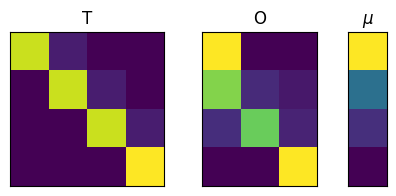

In [68]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(5,2)
ax[0].imshow(T)
ax[0].set_title("T")
ax[1].imshow(O)
ax[1].set_title("O")
ax[2].imshow(mu[:,None])
ax[2].set_title(r"$\mu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

We are now ready to use our parameters to generate a set of sequences which we will use to train our HMM.

In [69]:
from sequence_sampling import generate_sequence

n_sequences = 10_000
len_sequence = 200
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

states, observations = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (10000, 200)


We can compute some statistics for our sampled sequences:

1. average state at each iteration
2. mean likelihood of the sequences generated
3. distribution of observations at each time step
4. distribution of hidden states at each time steps

Note that the likelihood quickly approaches 0 as the sequence becomes longer. The final plot shows the distributions of different states over time. Towards the end, it is highly likely to be in the final state, from where no other transitions are possible.

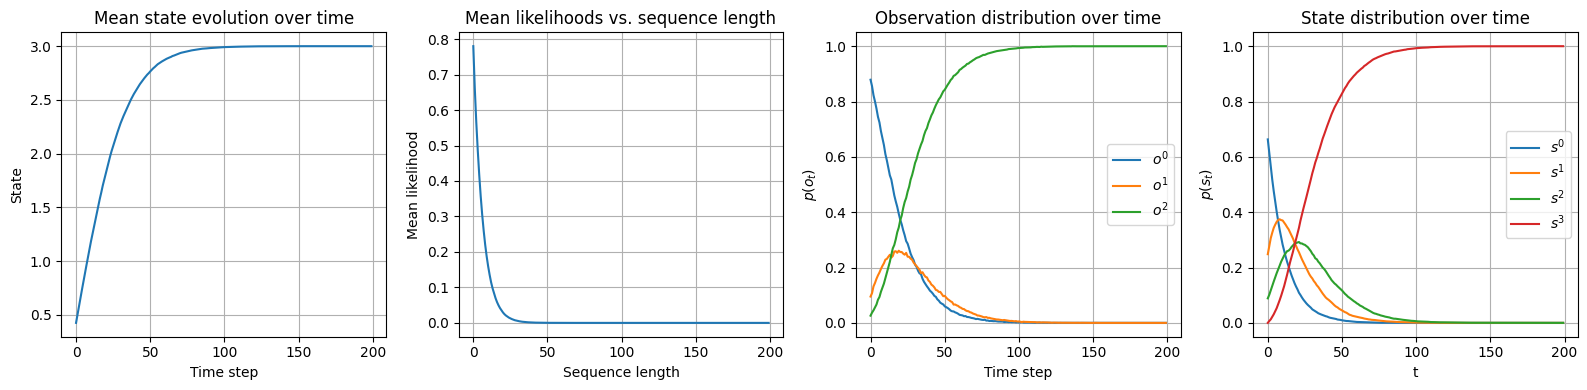

In [70]:
from likelihoods import likelihood

def plot_stats(states, observations):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    _, likelihoods = jax.vmap(lambda obs_seq: likelihood(obs_seq, T, O, mu))(observations)
    ax[1].set_title("Mean likelihoods vs. sequence length")
    ax[1].plot(jnp.mean(likelihoods, axis=0))
    ax[1].set_xlabel("Sequence length")
    ax[1].set_ylabel("Mean likelihood")
    ax[1].grid()

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(m)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[2].plot(obs_prob, label=f"$o^{k}$")
    ax[2].set_title("Observation distribution over time")
    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("Time step")
    ax[2].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[3].plot(state_prob, label=f"$s^{k}$")

    ax[3].set_title("State distribution over time")
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("$p(s_t)$")
    ax[3].grid()
    ax[3].legend()

    plt.tight_layout()
    plt.show()

plot_stats(states, observations)

We can now try to estimate the parameters using the vanilla version of the Baum-Welch algorithm.

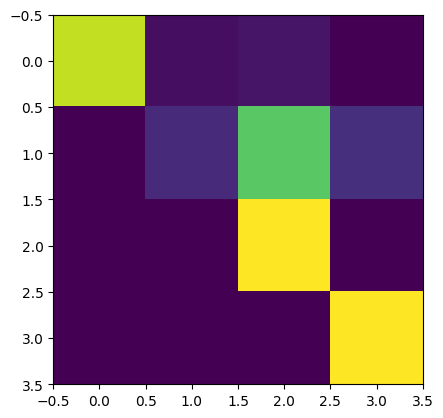

In [71]:
from inference import baum_welch

T_approx, O_approx = baum_welch(observations[:1000], jnp.triu(uniform(key(0), T.shape)), uniform(key(1), O.shape), mu, max_iter=1000, epsilon=1e-12)

plt.imshow(T_approx)
plt.show()

In [114]:
_, llhood = likelihood(observations[0], T_approx, O_approx, mu)
llhood[-1]

Array(1.976e-10, dtype=float32)

The likelihood estimate is not very good. However, we can improve upon this result by running the algorithm many times using slightly perturbed versions of the previous outcomes as the input.

In [128]:
from likelihoods import log_likelihood

n_steps = 10
n_train = 10
n_parallel = 10

best_llhood = -jnp.inf

T_approx = jnp.repeat(jnp.zeros_like(T)[None,...], n_parallel, axis=0)
O_approx = jnp.repeat(jnp.zeros_like(O)[None,...], n_parallel, axis=0)

T_best = jnp.triu(uniform(key(0), T.shape)) * jnp.tril(jnp.full_like(T, 1.0), 1)
O_best = uniform(key(1), O.shape)

for k in range(n_steps):
    T_init = jnp.mean(T_approx, axis=0) +  0.1 * jnp.triu(uniform(key(k), T.shape)) * jnp.tril(jnp.full_like(T, 1.0), 1)
    O_init = jnp.mean(O_approx, axis=0) +  0.1 * uniform(key(k + n_steps))
    T_init = T_init / jnp.sum(T_init, axis=1)[:, None]
    O_init = O_init / jnp.sum(O_init, axis=1)[:, None]
    
    train_indices = jax.random.choice(key(k), jnp.arange(len(observations)), (n_parallel, n_train), replace=True)

    T_approx, O_approx = jax.vmap(lambda idx: baum_welch(observations[idx], T_init, O_init, mu, epsilon=1e-8))(train_indices)

    _, logllhood = jax.vmap(lambda _obs: log_likelihood(_obs, jnp.mean(T_approx, axis=0), jnp.mean(O_approx, axis=0), mu))(observations)

    total_loglikelihood = jnp.sum(logllhood[:,-1])
    print(k, ":", total_loglikelihood, end="\r")
    if total_loglikelihood >= best_llhood:
        T_best = T_approx.copy()
        O_best = O_approx.copy()
        best_llhood = total_loglikelihood
        print(k, ":", best_llhood)
print(best_llhood)


0 : -1.5701995e+06
-1.5701995e+06+066


In [129]:
_, true_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T, O, mu))(observations)
print("True likelihood of training sequence:", jnp.sum(true_llhood[:,-1]))

True likelihood of training sequence: -4.5302645e+06


[1. 1. 1. 1.]
[[[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.975 0.025]
  [0.    0.    0.    1.   ]]

 [[0.492 0.508 0.    0.   ]
  [0.    0.348 0.652 0.   ]
  [0.    0.    0.9

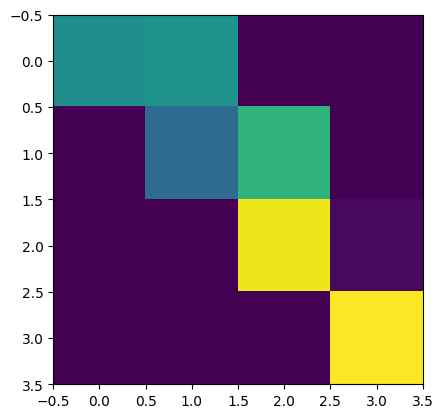

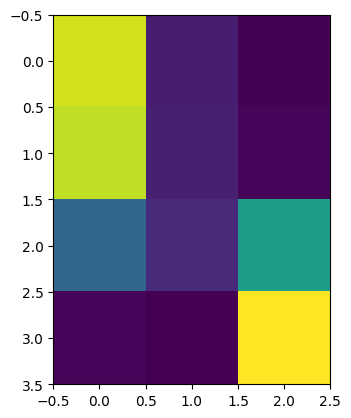

In [ ]:
print(jnp.sum(T_best, axis=1))
print(T_best)

plt.imshow(T_best)
plt.show()
plt.imshow(O_best)
plt.show()

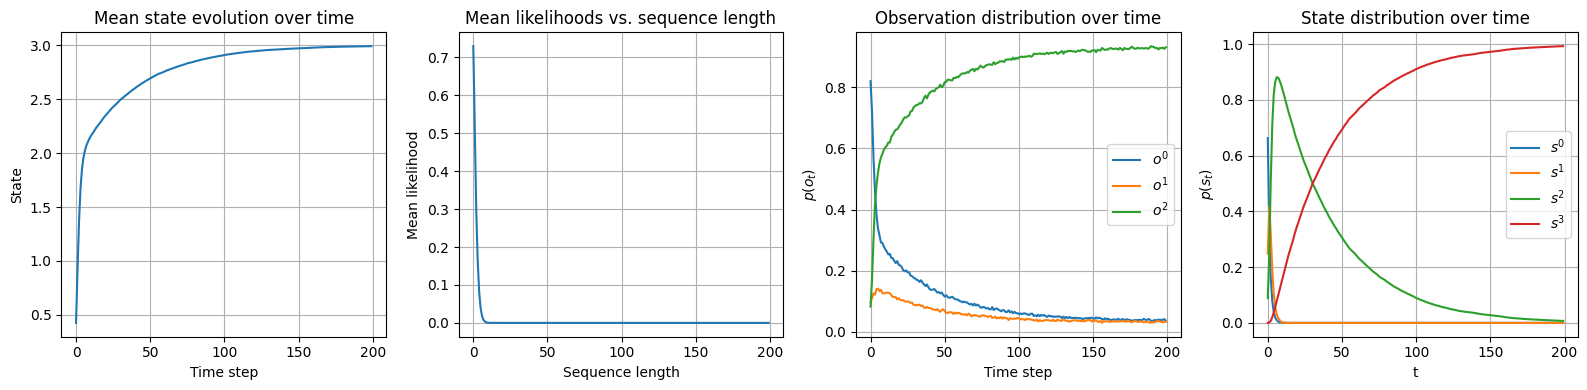

In [123]:
states_approx, obs_approx = jax.vmap(lambda _key: generate_sequence(_key, T_best, O_best, mu, len_sequence))(jnp.array(sequence_keys))
plot_stats(states_approx, obs_approx)

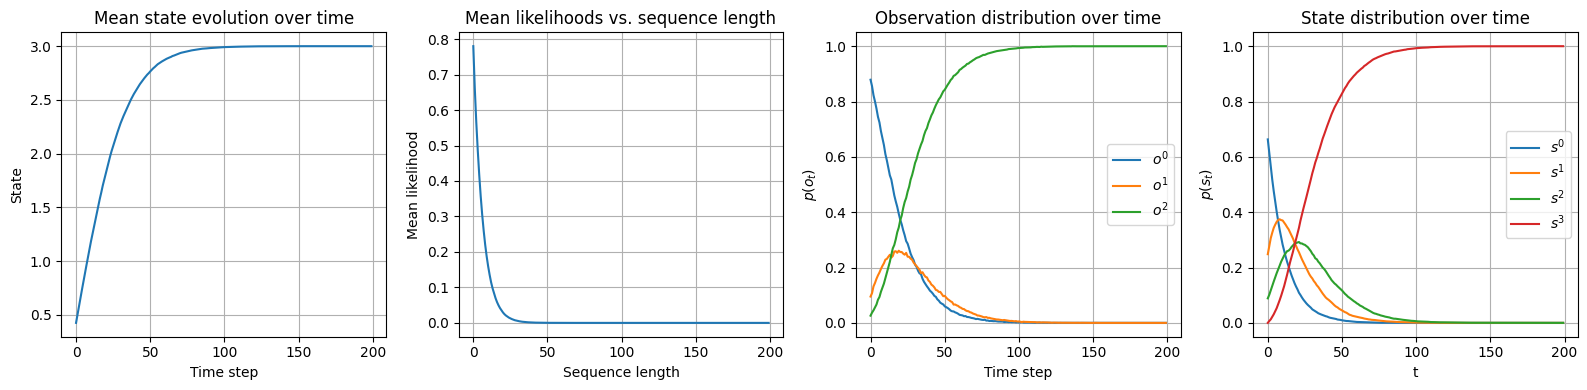

In [78]:
plot_stats(states, observations)